In [ ]:
# Install FEniCS
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

--2024-03-19 10:45:15--  https://fem-on-colab.github.io/releases/fenics-install-real.sh
Resolving fem-on-colab.github.io (fem-on-colab.github.io)... 185.199.110.153, 185.199.109.153, 185.199.111.153, ...
Connecting to fem-on-colab.github.io (fem-on-colab.github.io)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4161 (4.1K) [application/x-sh]
Saving to: ‘/tmp/fenics-install.sh’

/tmp/fenics-install 100%[===================>]   4.06K  --.-KB/s    in 0s      

2024-03-19 10:45:15 (26.1 MB/s) - ‘/tmp/fenics-install.sh’ saved [4161/4161]

+ INSTALL_PREFIX=/usr/local
++ echo /usr/local
++ awk -F/ '{print NF-1}'
+ INSTALL_PREFIX_DEPTH=2
+ PROJECT_NAME=fem-on-colab
+ SHARE_PREFIX=/usr/local/share/fem-on-colab
+ FENICS_INSTALLED=/usr/local/share/fem-on-colab/fenics.installed
+ [[ ! -f /usr/local/share/fem-on-colab/fenics.installed ]]
+ PYBIND11_INSTALL_SCRIPT_PATH=https://github.com/fem-on-colab/fem-on-colab.github.io/raw/c3d2317/releases/pybind11-inst

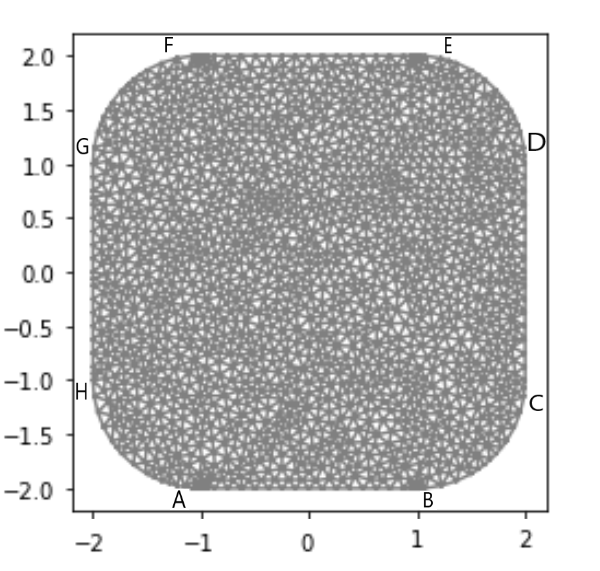

**Example:**

Consider 2D heat transfer across a plate  of thermal conductivity $\kappa = 0.935 W/mºC $ shown in the figure.
Governing Equation for Heat Transfer Derived from
Fourier's law:

\begin{alignat}{2}
 - \nabla.(\kappa \nabla u) &=  f \quad &&\hbox{ in }\Omega, \tag{1}
\end{alignat}

We define the heat flux boundary conditions:

\begin{alignat}{2}
-\kappa{\partial u\over\partial n} &= 100 W/mm \quad&&\mbox{ on } (CD) \mbox{ and } (GH),\quad \tag{2}\\
-\kappa{\partial u\over\partial n} &= 750(T-75) \quad&&\mbox{ on } (DE) \mbox{ and } (FG),\quad \tag{3}\\
-\kappa{\partial u\over\partial n} &= 0 \quad&&\mbox{ on } (AB) \mbox{
   and } (EF),\quad \tag{4}
\end{alignat}

Dirichlet boundary condition:
$$  
u = 75, \quad \mbox{ on } (BC) \mbox{ and } (HA),\quad \tag{5}$$

The load:
$$f = 2\cos^2 x \sin^2 y, \quad \mbox{in }\Omega,\quad \tag{6}$$

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
from mshr import *
#
# to plot the result in the Notebook
%matplotlib inline


dim(Vh) =  1769


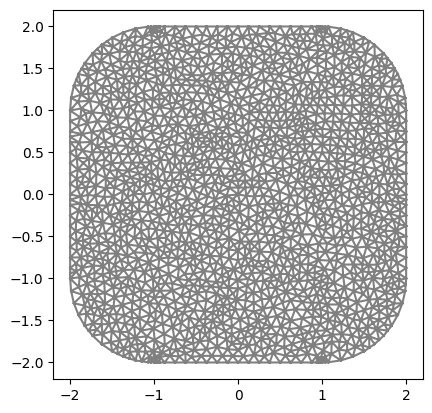

In [ ]:
d = 1

A= Point(-2,1)
B = Point(-1,2)

circ_rad = 1
circ1 = Circle(Point(-1.0, 1.0),circ_rad) # top right circle
circ2 = Circle(Point(1.0, 1.0),circ_rad) # top left circle
circ3 = Circle(Point(-1.0, -1.0),circ_rad) # bottom right circle
circ4 = Circle(Point(1.0, -1.0),circ_rad) # bottom left circle

domain1 = Rectangle(A, B)-circ1

C= Point(1,1)
D = Point(2,2)
domain2 = Rectangle(C, D)- circ2

E= Point(-2,-1)
F = Point(-1,-2)
domain3 = Rectangle(E, F)- circ3

G= Point(2,-1)
H = Point(1,-2)
domain4 = Rectangle(G, H)- circ4

domain = domain1+domain2+domain3+domain4

I= Point(-2,-2)
J = Point(2,2)

domain5 = Rectangle(I, J)- domain

# Generate Mesh
mesh = generate_mesh(domain5, 30)
plot(mesh)
Vh  = FunctionSpace(mesh, 'P', d)
print ("dim(Vh) = ", Vh.dim())

In [ ]:
g = Constant(0.)
g_1 = Constant(100.)
h  = Constant(750.0)
T0 = Constant(75.0) # for external shape
u_0 = Constant(75.)
kappa = Constant(2.5)
f = Expression('2*((cos(x[0]) * cos(x[0])) + sin(x[1]) * sin(x[1]))', degree=d+2)

In [ ]:
#
#  Define Dirichlet boundary condition
#
def Bottom_left_circ(x, on_boundary):
  return on_boundary and (between(x[1], (-2.0, -1.0)) and between(x[0], (-2.0, -1.0)))

bc1 = DirichletBC(Vh, u_0, Bottom_left_circ)
#
def Bottom_Right_circ(x, on_boundary):
  return on_boundary and (between(x[1], (-2.0, -1.0)) and between(x[0], (1.0, 2.0)))

bc2 = DirichletBC(Vh, u_0, Bottom_Right_circ)
#
bc=[bc1, bc2]

In [ ]:
#
# Define boundary labels
#
class LeftBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] , 2.) and between(x[1] , (-1.,1.))

class RightBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[0] , -2.) and between(x[1] , (-1.,1.))

class BottomBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1] , -2.0) and between(x[0] , (-1.,1.))

class TopBoundary(SubDomain):
  def inside(self, x, on_boundary):
    return on_boundary and near(x[1], 2.0) and between(x[0] , (-1.,1.))

class Top_Right_circ(SubDomain):
    def inside(self, x, on_boundary):
      return (on_boundary) and (between(x[1], (1.0, 2.0)) and between(x[0], (1.0, 2.0)))

class Top_Left_circ(SubDomain):
    def inside(self, x, on_boundary):
      return (on_boundary) and (between(x[1], (1.0, 2.0)) and between(x[0], (-2.0, -1.0)))

leftBoundary = LeftBoundary()
rightBoundary = RightBoundary()
topBoundary = TopBoundary()
bottomBoundary = BottomBoundary()
top_right_circ = Top_Right_circ()
top_left_circ = Top_Left_circ()
#
# Initialize mesh function for boundary domains
#
boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
#
# mark the entire boundary as 0
#
boundaries.set_all(0)
#
# Mark the Neumann and isolated parts of the boundaries as subdomains  1 and 2
#
rightBoundary.mark(boundaries, 1)
leftBoundary.mark(boundaries, 1)
topBoundary.mark(boundaries, 2)
bottomBoundary.mark(boundaries, 2)
#
# Mark the convective parts of the boundaries as 3
#
top_right_circ.mark(boundaries, 3)
top_left_circ.mark(boundaries, 3)
#
#  ds: surface integration
#
ds=Measure('ds', domain=mesh, subdomain_data=boundaries)

In [ ]:
#  weak form
u = TrialFunction(Vh)
v = TestFunction(Vh)
#
a = kappa*dot(grad(u), grad(v))*dx + h*u*v*ds(3)
L =  f*v*dx + g_1*v*ds(1) + g*v*ds(2) + h*T0*v*ds(3)
#

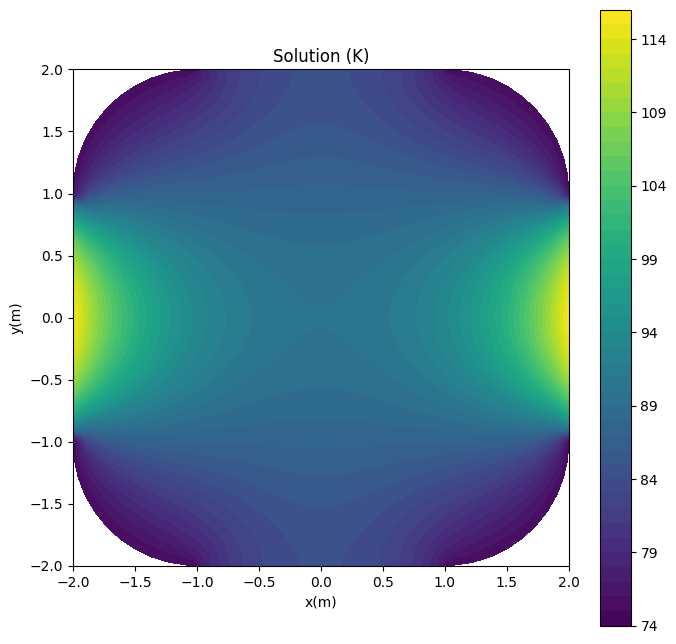

In [ ]:
uh = Function(Vh)
#
# Solution
solve(a==L, uh, bc)
#
plt.figure(figsize=(8,8))
p = plot(uh)
plt.title('Solution (K)')
plt.xlabel('x(m)')
plt.ylabel('y(m)')
plt.colorbar(p)